# **[PlantVillage Disease Classification Challenge](https://www.crowdai.org/challenges/plantvillage-disease-classification-challenge)**

PlantVillage is built on the premise that all knowledge that helps people grow food should be openly accessible to anyone on the planet.

**Overview**

We depend on edible plants just as we depend on oxygen. Without crops, there is no food, and without food, there is no life. It's no accident that human civilization began to thrive with the invention of agriculture.

Today, modern technology allows us to grow crops in quantities necessary for a steady food supply for billions of people. But diseases remain a major threat to this supply, and a large fraction of crops are lost each year to diseases. The situation is particularly dire for the 500 million smallholder farmers around the globe, whose livelihoods depend on their crops doing well. In Africa alone, 80% of the agricultural output comes from smallholder farmers.

With billions of smartphones around the globe, wouldn't it be great if the smartphone could be turned into a disease diagnostics tool, recognizing diseases from images it captures with its camera? This challenge is the first of many steps turning this vision into a reality. PlantVillage is a not-for-profit project by Penn State University in the US and EPFL in Switzerland. We have collected - and continue to collect - tens of thousands of images of diseased and healthy crops. ***The goal of this challenge is to develop algorithms than can accurately diagnose a disease based on an image.***

Here are the 38 classes of crop disease pairs that the dataset is offering.  To learn more about the background of the dataset, please refer to the following paper: https://arxiv.org/abs/1511.08060v2. You must cite this paper if you use the dataset. 



**Evaluation**

Submissions will be evaluated using a Multi Class Log Loss evaluation function.

In [1]:
import os
import pandas as pd
import numpy as np
import random
import cv2
import pathlib
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from IPython.display import SVG
import IPython.display as display

from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

import warnings
warnings.filterwarnings("ignore")

from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions


import keras.backend as K
from keras.models import Sequential

from keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input

import time as tm

Using TensorFlow backend.


Next will be show few images samples from the data set:

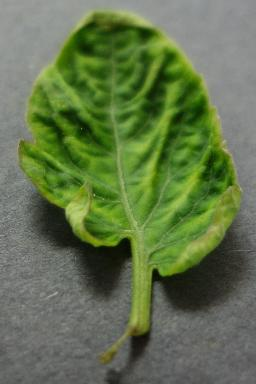

['c_35', '39cd6c3d-f927-4992-9a8c-df459752aab6___UF.GRC_YLCV_Lab 01887.JPG']


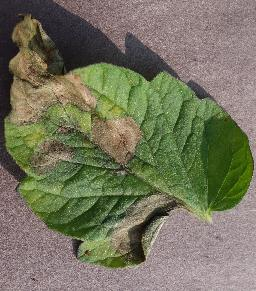

['c_30', '2c2326e9-eb07-45c1-8296-116df4108c03___RS_Late.B 4834.JPG']


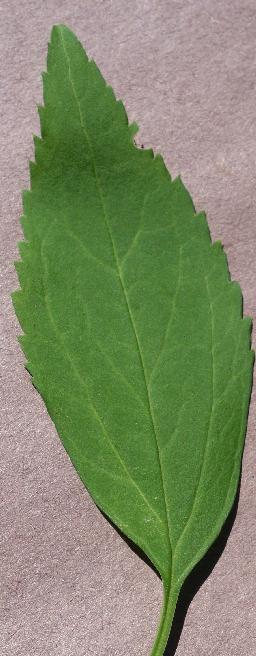

['c_6', 'c3c041f1-dac2-4110-ae56-1818774b4603___JR_HL 4208.JPG']


In [2]:
rootDir = 'crowdai'
data_root = pathlib.Path(rootDir)
all_image_paths = list(data_root.glob('*/*'))
for i in range(0,3):
    image_example = str(random.choice(all_image_paths))
    display.display(display.Image(image_example))
    print(image_example.split("/")[-2:])
# The first value correspond to folder name and it is its label, next values is the file name

The first value correspond image folder name and it's its label, and next value is the file name

# Load data and create labels

- Create function to read the files in root, and get a list with labels and image names.

After several attempts, and try different aproach, I  choose this way, because the way of dataframe was created keep the same read system order, because the classes or labels are in the same order that jupyter is reading the data, and the code is more clean than other approachs I did tested. I like this consistency, even though the data reading is more slow, but I'm keeping this approach for this work.

In [3]:
def make_labels(rootDir):
    '''
    From a given root, this function return a pandas dataframe with the classes and file names
    The data read is slow but it garanties the order in pandas, as pc read the files.
    inpu:
        rootDir: Root dir which contains the files by classes folder names
    return:
        d: Is an empty dataframe, wich is populated by files names and ist respective classes.
    '''
    df = pd.DataFrame()   
    idx = 0 
    for lists in os.listdir(rootDir): 
        path = os.path.join(rootDir, lists)
        aux_list = []
        for path, dirs, files in os.walk(path):
            key = path.split("/")[-1:][0]
            for file in files:
                temp = pd.DataFrame({'label': key, 'img':file},index=[idx])
                idx +=1
                df = pd.concat([df, temp])
    return df


The next are the function test, in order to get classes and files names from folders.

In [4]:
df = make_labels(rootDir)
df.head()

,label,img
0,c_1,f2b57a5b-f46d-453a-bb33-21d01d8a10de___JR_FrgE...
1,c_1,73b7ad12-02d0-4775-8f51-c7d404177132___JR_FrgE...
2,c_1,50afe8c7-d56e-4dd0-97b8-23a70ddca819___JR_FrgE...
3,c_1,1ce4ecdf-fe69-42df-a0dc-c90f5495e7a1___JR_FrgE...
4,c_1,464511a6-77d9-493f-bb3c-f151fb390f1b___JR_FrgE...


In [5]:
# Read file function

def get_im_cv2(path):
    img = cv2.imread(path)
    resized = cv2.resize(img, (64, 64), cv2.INTER_LINEAR)
    return resized

In [6]:
# file read checking
path = '../crowdai/c_1/f2b57a5b-f46d-453a-bb33-21d01d8a10de___JR_FrgE.S 3036.JPG'
a = cv2.imread(path)
a

In [7]:
# Data vectors load function
# source: https://www.kaggle.com/satian/keras-mobilenet-starter

def load_img(df):
    '''
    '''    
    m = df.shape[0]
    X = np.zeros((m, 64, 64, 3))
    count = 0
    for i in range(0,m):
        img = image.load_img(rootDir+"/"+df.ix[i][0]+"/"+df.ix[i][1], target_size=(64, 64, 3))
        x = image.img_to_array(img)
        x = preprocess_input(x)
        X[count] = x
        if (count%1000 == 0):
            print("Processing image: ", count+1, ", ", df['img'][i])
        count += 1
    label = list(df)[0]
    values = np.array(df[label])
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    y = onehot_encoded    
    
    return X, y, label_encoder
    


## Data drop

As experiment accuracy doesn't improve, this was 0.10 in average.  Maybe it must because data classes are imbalanced, as you can see in the next tables. In order to surpase this, I will try increasing the number of images repeating the numbers of images accord to proportion of the maximum images class.  First, I compute the number of times a class has with respect the maximum number image per class.  Then i will copy many times the class as it is in the minimum number of image in a class.

In [8]:
df_grouped = df.groupby(['label']).count().reset_index().copy().sort_values('img', ascending=False)
df_grouped

,label,img
7,c_15,2321
29,c_35,2100
17,c_24,1917
8,c_16,962
21,c_28,792
18,c_25,749
26,c_32,734
24,c_30,726
27,c_33,720
23,c_3,713


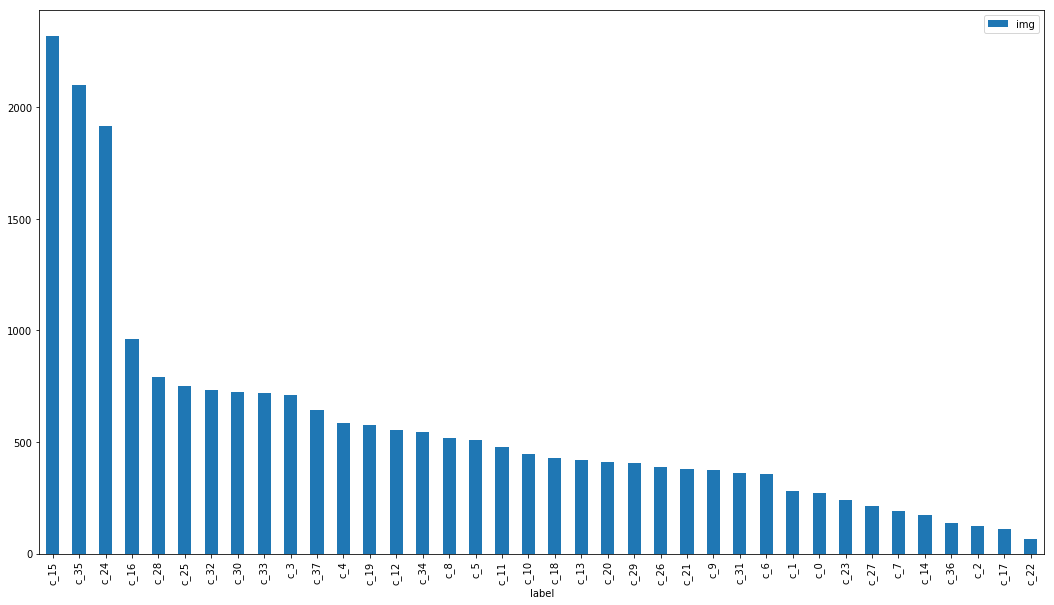

In [9]:
df_grouped.plot.bar(x ='label', figsize=(18,10))

In [10]:
df_grouped.describe()

,img
count,38.000000
mean,576.763158
std,505.201027
min,64.000000
25%,299.500000
50%,436.500000
75%,695.500000
max,2321.000000


The data is completely imbalanced, for that reason, must be find an approach to handle with this imbalances before the feed the Neural network. 

https://towardsdatascience.com/handling-imbalanced-datasets-in-deep-learning-f48407a0e758

Oversampling with gans

https://github.com/JeffersonLPLima/adversarial_oversampling


https://medium.com/neuralspace/kaggle-1-winning-approach-for-image-classification-challenge-9c1188157a86


https://github.com/kumar-shridhar/CNN_Architectures/blob/master/Resnet50/resnet50.ipynb

I make a copy of dataframe with file data information

In [11]:
k = 1000

In [12]:
df2 =pd.DataFrame(columns=['label','img'])
for index,row in df_grouped.iterrows():
    df_aux = df[df.label == row['label']].copy()
    if len(df_aux) > k:
        df_sample = df_aux.sample(n=k).reset_index(drop=True)
    else:
        df_sample = df_aux
    print(df_sample.shape)
    df2 = df2.append(df_sample,ignore_index=True)
    #df_n = pd.concat([df2, df_n_aux],ignore_index=True) 
    print(df2.shape)

    
df2.shape
        #pd.concat([df]*3, ignore_index=True)

(1000, 2)
(1000, 2)
(1000, 2)
(2000, 2)
(1000, 2)
(3000, 2)
(962, 2)
(3962, 2)
(792, 2)
(4754, 2)
(749, 2)
(5503, 2)
(734, 2)
(6237, 2)
(726, 2)
(6963, 2)
(720, 2)
(7683, 2)
(713, 2)
(8396, 2)
(643, 2)
(9039, 2)
(586, 2)
(9625, 2)
(577, 2)
(10202, 2)
(552, 2)
(10754, 2)
(547, 2)
(11301, 2)
(519, 2)
(11820, 2)
(510, 2)
(12330, 2)
(476, 2)
(12806, 2)
(445, 2)
(13251, 2)
(428, 2)
(13679, 2)
(420, 2)
(14099, 2)
(412, 2)
(14511, 2)
(405, 2)
(14916, 2)
(390, 2)
(15306, 2)
(380, 2)
(15686, 2)
(374, 2)
(16060, 2)
(360, 2)
(16420, 2)
(358, 2)
(16778, 2)
(280, 2)
(17058, 2)
(270, 2)
(17328, 2)
(240, 2)
(17568, 2)
(214, 2)
(17782, 2)
(191, 2)
(17973, 2)
(171, 2)
(18144, 2)
(139, 2)
(18283, 2)
(124, 2)
(18407, 2)
(108, 2)
(18515, 2)
(64, 2)
(18579, 2)


(18579, 2)

In [13]:
df2.shape

(18579, 2)

In [14]:
df_grouped2 = df2.groupby(['label']).count().reset_index().copy().sort_values('img', ascending=False)
df_grouped2

,label,img
17,c_24,1000
7,c_15,1000
29,c_35,1000
8,c_16,962
21,c_28,792
18,c_25,749
26,c_32,734
24,c_30,726
27,c_33,720
23,c_3,713


In [15]:
df_grouped2.describe()

,img
count,38.000000
mean,488.921053
std,261.428651
min,64.000000
25%,299.500000
50%,436.500000
75%,695.500000
max,1000.000000


In [16]:
X, y, label_encoder = load_img(df2)

Processing image:  1 ,  7fd72dc3-7e5f-4235-bd2f-74627108fbc3___UF.Citrus_HLB_Lab 0279.JPG
Processing image:  1001 ,  d7b8486a-ca45-46e0-9087-8d10804ac55b___UF.GRC_YLCV_Lab 09425.JPG
Processing image:  2001 ,  90c417d5-6d8b-45c8-b145-d3973ff396fe___RS_HL 5920.JPG
Processing image:  3001 ,  dba846ad-67ee-4a38-be9f-f4d76532a350___Rut._Bact.S 1041.JPG
Processing image:  4001 ,  df6c7120-ac7c-43b5-bb2a-3c61782e7a47___GCREC_Bact.Sp 6030.JPG
Processing image:  5001 ,  b5c8d263-334f-4e02-9155-86c3447e689a___UMD_Powd.M 9626.JPG
Processing image:  6001 ,  4ca205ed-57b5-4d2a-ba00-a706e9b9ffed___Keller.St_CG 1966.JPG
Processing image:  7001 ,  4f355304-d619-4594-8370-a0863049bf4d___Com.G_SpM_FL 8981.JPG
Processing image:  8001 ,  950e5c9d-49ec-4c5c-af23-69efff18f8a6___RS_HL 5749.JPG
Processing image:  9001 ,  488feb1c-4b9f-44e7-8aa6-4103a9601f5f___GH_HL Leaf 434.JPG
Processing image:  10001 ,  06ae69f3-53f7-4ad8-b6b0-185dd26b2fc0___JR_HL 7971.JPG
Processing image:  11001 ,  0fccb8d0-3f91-442c-8d74

In [17]:
_, NUM_CLASSES = y.shape
NUM_CLASSES

38

In [18]:
# Data split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=123)

In [19]:
# Image Standarization

data_generator = image.ImageDataGenerator(rescale=1./255,
                                          rotation_range=75,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          featurewise_center=True,
                                          featurewise_std_normalization=True,
                                          horizontal_flip=True,
                                          zoom_range=0.3,
                                          samplewise_std_normalization=True)

data_generator.fit(X_train)

# standardize the test set
for i in range(len(X_test)):
    X_test[i] = data_generator.standardize(X_test[i])

## Neural Network Model

In [20]:
def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

The first mode to train is a Resnet 50 with original data.

In [21]:
# Resnet50 model
base_model = ResNet50(input_shape=(64, 64, 3),include_top=False,weights= 'imagenet')

print(base_model.summary())

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
_____________________________________

In [22]:
# https://www.kaggle.com/amadeus1996/fruits-360-transfer-learning-using-keras

x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
#x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
#x = Dense(512, activation='relu')(x)
# and a fully connected output/classification layer
predictions = Dense(NUM_CLASSES, activation='softmax')(x)
# create the full network so we can train on it
inception_transfer = Model(inputs=base_model.input, outputs=predictions)

In [23]:
inception_transfer.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy',
              metrics=['acc'])

In [24]:
# https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/
# https://keras.io/models/sequential/
batch_size=256
epochs = 500
ini = tm.time()

history =inception_transfer.fit_generator(
    generator=data_generator.flow(x=X_train,
                                  y=y_train,
                                  batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    shuffle = True, 
    verbose = 1,
    validation_data=(X_test, y_test))
end = tm.time()

elapsed = end - ini
print(elapsed/3600)

Instructions for updating:
Use tf.cast instead.
Epoch 1/500
58/58 [==============================] - 23s 403ms/step - loss: 1.8260 - acc: 0.5537 - val_loss: 0.6915 - val_acc: 0.7944
Epoch 2/500
58/58 [==============================] - 15s 264ms/step - loss: 1.1706 - acc: 0.6839 - val_loss: 0.5918 - val_acc: 0.8205
Epoch 3/500
58/58 [==============================] - 15s 257ms/step - loss: 0.7681 - acc: 0.7779 - val_loss: 0.4255 - val_acc: 0.8751
Epoch 4/500
58/58 [==============================] - 15s 259ms/step - loss: 0.5875 - acc: 0.8306 - val_loss: 0.4539 - val_acc: 0.8735
Epoch 5/500
58/58 [==============================] - 15s 261ms/step - loss: 0.5434 - acc: 0.8382 - val_loss: 0.3279 - val_acc: 0.9029
Epoch 6/500
58/58 [==============================] - 15s 259ms/step - loss: 0.4411 - acc: 0.8726 - val_loss: 0.2918 - val_acc: 0.9107
Epoch 7/500
58/58 [==============================] - 15s 264ms/step - loss: 0.3883 - acc: 0.8859 - val_loss: 0.2772 - val_acc: 0.9225
Epoch 8/500
58

Epoch 60/500
58/58 [==============================] - 15s 259ms/step - loss: 0.0985 - acc: 0.9678 - val_loss: 0.1143 - val_acc: 0.9666
Epoch 61/500
58/58 [==============================] - 15s 256ms/step - loss: 0.1140 - acc: 0.9661 - val_loss: 0.1133 - val_acc: 0.9626
Epoch 62/500
58/58 [==============================] - 15s 257ms/step - loss: 0.1049 - acc: 0.9662 - val_loss: 0.1122 - val_acc: 0.9674
Epoch 63/500
58/58 [==============================] - 15s 257ms/step - loss: 0.1447 - acc: 0.9565 - val_loss: 0.1166 - val_acc: 0.9615
Epoch 64/500
58/58 [==============================] - 15s 256ms/step - loss: 0.1394 - acc: 0.9596 - val_loss: 0.1103 - val_acc: 0.9669
Epoch 65/500
58/58 [==============================] - 15s 257ms/step - loss: 0.0785 - acc: 0.9739 - val_loss: 0.1102 - val_acc: 0.9677
Epoch 66/500
58/58 [==============================] - 15s 257ms/step - loss: 0.0945 - acc: 0.9731 - val_loss: 0.0980 - val_acc: 0.9693
Epoch 67/500
58/58 [==============================] - 1

58/58 [==============================] - 15s 257ms/step - loss: 0.5395 - acc: 0.8512 - val_loss: 0.3220 - val_acc: 0.9098
Epoch 121/500
58/58 [==============================] - 15s 257ms/step - loss: 0.3743 - acc: 0.8983 - val_loss: 0.2326 - val_acc: 0.9411
Epoch 122/500
58/58 [==============================] - 15s 256ms/step - loss: 0.3154 - acc: 0.9202 - val_loss: 0.2537 - val_acc: 0.9400
Epoch 123/500
58/58 [==============================] - 15s 256ms/step - loss: 0.2730 - acc: 0.9326 - val_loss: 0.2517 - val_acc: 0.9386
Epoch 124/500
58/58 [==============================] - 15s 257ms/step - loss: 0.2495 - acc: 0.9391 - val_loss: 0.2074 - val_acc: 0.9561
Epoch 125/500
58/58 [==============================] - 15s 257ms/step - loss: 0.2067 - acc: 0.9514 - val_loss: 0.1943 - val_acc: 0.9572
Epoch 126/500
58/58 [==============================] - 15s 257ms/step - loss: 0.2964 - acc: 0.9261 - val_loss: 0.2243 - val_acc: 0.9491
Epoch 127/500
58/58 [==============================] - 15s 257

58/58 [==============================] - 15s 257ms/step - loss: 0.1879 - acc: 0.9452 - val_loss: 0.1305 - val_acc: 0.9626
Epoch 181/500
58/58 [==============================] - 15s 257ms/step - loss: 0.1272 - acc: 0.9633 - val_loss: 0.1135 - val_acc: 0.9658
Epoch 182/500
58/58 [==============================] - 15s 257ms/step - loss: 0.0739 - acc: 0.9760 - val_loss: 0.1087 - val_acc: 0.9696
Epoch 183/500
58/58 [==============================] - 15s 257ms/step - loss: 0.0983 - acc: 0.9727 - val_loss: 0.1064 - val_acc: 0.9707
Epoch 184/500
58/58 [==============================] - 15s 257ms/step - loss: 0.0948 - acc: 0.9744 - val_loss: 0.1009 - val_acc: 0.9712
Epoch 185/500
58/58 [==============================] - 15s 257ms/step - loss: 0.0877 - acc: 0.9746 - val_loss: 0.0821 - val_acc: 0.9769
Epoch 186/500
58/58 [==============================] - 15s 257ms/step - loss: 0.1051 - acc: 0.9690 - val_loss: 0.0985 - val_acc: 0.9707
Epoch 187/500
58/58 [==============================] - 15s 257

58/58 [==============================] - 15s 257ms/step - loss: 0.1979 - acc: 0.9504 - val_loss: 0.1523 - val_acc: 0.9580
Epoch 241/500
58/58 [==============================] - 15s 257ms/step - loss: 0.1694 - acc: 0.9609 - val_loss: 0.1063 - val_acc: 0.9693
Epoch 242/500
58/58 [==============================] - 15s 257ms/step - loss: 0.6084 - acc: 0.8296 - val_loss: 0.2687 - val_acc: 0.9174
Epoch 243/500
58/58 [==============================] - 15s 256ms/step - loss: 0.2806 - acc: 0.9168 - val_loss: 0.1997 - val_acc: 0.9429
Epoch 244/500
58/58 [==============================] - 15s 257ms/step - loss: 0.2150 - acc: 0.9335 - val_loss: 0.1716 - val_acc: 0.9494
Epoch 245/500
58/58 [==============================] - 15s 257ms/step - loss: 0.2213 - acc: 0.9375 - val_loss: 0.1640 - val_acc: 0.9526
Epoch 246/500
58/58 [==============================] - 15s 257ms/step - loss: 0.2057 - acc: 0.9396 - val_loss: 0.1502 - val_acc: 0.9567
Epoch 247/500
58/58 [==============================] - 15s 257

58/58 [==============================] - 15s 265ms/step - loss: 0.0681 - acc: 0.9802 - val_loss: 0.0994 - val_acc: 0.9723
Epoch 301/500
58/58 [==============================] - 15s 257ms/step - loss: 0.0582 - acc: 0.9855 - val_loss: 0.0869 - val_acc: 0.9766
Epoch 302/500
58/58 [==============================] - 15s 257ms/step - loss: 0.0523 - acc: 0.9830 - val_loss: 0.1543 - val_acc: 0.9629
Epoch 303/500
58/58 [==============================] - 15s 259ms/step - loss: 0.0490 - acc: 0.9866 - val_loss: 0.1116 - val_acc: 0.9707
Epoch 304/500
58/58 [==============================] - 15s 258ms/step - loss: 0.0715 - acc: 0.9802 - val_loss: 0.1125 - val_acc: 0.9726
Epoch 305/500
58/58 [==============================] - 15s 258ms/step - loss: 0.0606 - acc: 0.9869 - val_loss: 0.1132 - val_acc: 0.9747
Epoch 306/500
58/58 [==============================] - 15s 258ms/step - loss: 0.0436 - acc: 0.9904 - val_loss: 0.0961 - val_acc: 0.9769
Epoch 307/500
58/58 [==============================] - 15s 258

58/58 [==============================] - 15s 256ms/step - loss: 0.1627 - acc: 0.9711 - val_loss: 0.2095 - val_acc: 0.9572
Epoch 361/500
58/58 [==============================] - 15s 257ms/step - loss: 0.1682 - acc: 0.9688 - val_loss: 0.1929 - val_acc: 0.9656
Epoch 362/500
58/58 [==============================] - 15s 257ms/step - loss: 0.2127 - acc: 0.9554 - val_loss: 0.1980 - val_acc: 0.9607
Epoch 363/500
58/58 [==============================] - 15s 256ms/step - loss: 0.1726 - acc: 0.9670 - val_loss: 0.1819 - val_acc: 0.9637
Epoch 364/500
58/58 [==============================] - 15s 257ms/step - loss: 0.1455 - acc: 0.9753 - val_loss: 0.1786 - val_acc: 0.9656
Epoch 365/500
58/58 [==============================] - 15s 257ms/step - loss: 0.1895 - acc: 0.9603 - val_loss: 0.2234 - val_acc: 0.9586
Epoch 366/500
58/58 [==============================] - 15s 257ms/step - loss: 0.1975 - acc: 0.9582 - val_loss: 0.1939 - val_acc: 0.9637
Epoch 367/500
58/58 [==============================] - 15s 257

58/58 [==============================] - 15s 257ms/step - loss: 0.1450 - acc: 0.9734 - val_loss: 0.1573 - val_acc: 0.9696
Epoch 421/500
58/58 [==============================] - 15s 256ms/step - loss: 0.1488 - acc: 0.9750 - val_loss: 0.1582 - val_acc: 0.9696
Epoch 422/500
58/58 [==============================] - 15s 257ms/step - loss: 0.1725 - acc: 0.9635 - val_loss: 0.1548 - val_acc: 0.9693
Epoch 423/500
58/58 [==============================] - 15s 256ms/step - loss: 0.0967 - acc: 0.9814 - val_loss: 0.1724 - val_acc: 0.9693
Epoch 424/500
58/58 [==============================] - 15s 257ms/step - loss: 0.1324 - acc: 0.9702 - val_loss: 0.1411 - val_acc: 0.9701
Epoch 425/500
58/58 [==============================] - 15s 257ms/step - loss: 0.1153 - acc: 0.9771 - val_loss: 0.1372 - val_acc: 0.9685
Epoch 426/500
58/58 [==============================] - 15s 257ms/step - loss: 0.1008 - acc: 0.9786 - val_loss: 0.1490 - val_acc: 0.9715
Epoch 427/500
58/58 [==============================] - 15s 256

58/58 [==============================] - 15s 256ms/step - loss: 0.1804 - acc: 0.9596 - val_loss: 0.1957 - val_acc: 0.9604
Epoch 481/500
58/58 [==============================] - 15s 257ms/step - loss: 0.1267 - acc: 0.9698 - val_loss: 0.1726 - val_acc: 0.9642
Epoch 482/500
58/58 [==============================] - 15s 257ms/step - loss: 0.3429 - acc: 0.9118 - val_loss: 0.2456 - val_acc: 0.9419
Epoch 483/500
58/58 [==============================] - 15s 256ms/step - loss: 0.2235 - acc: 0.9472 - val_loss: 0.2248 - val_acc: 0.9537
Epoch 484/500
58/58 [==============================] - 15s 257ms/step - loss: 0.2330 - acc: 0.9445 - val_loss: 0.2131 - val_acc: 0.9470
Epoch 485/500
58/58 [==============================] - 15s 257ms/step - loss: 0.1656 - acc: 0.9584 - val_loss: 0.2176 - val_acc: 0.9529
Epoch 486/500
58/58 [==============================] - 15s 256ms/step - loss: 0.1752 - acc: 0.9580 - val_loss: 0.1812 - val_acc: 0.9602
Epoch 487/500
58/58 [==============================] - 15s 257

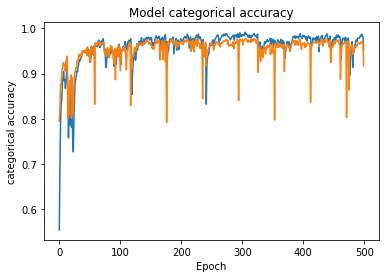

In [25]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model categorical accuracy')
plt.ylabel('categorical accuracy')
plt.xlabel('Epoch')
plt.show()